# CAPTCHA

In this notebook the problem of optical character recognition of letter sequences from image is considered.

In [1]:
import os
import json
import datetime
import editdistance

import pandas as pd
import numpy as np

from keras import backend as K
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import GRU, Bidirectional
from keras.layers import Dense, TimeDistributed
from keras.layers import Input, Permute, Reshape, Lambda, Merge
from keras.models import Model, model_from_json
from keras.optimizers import SGD
from keras.callbacks import Callback
from keras.utils.vis_utils import model_to_dot
from keras.utils.data_utils import get_file

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from IPython.display import SVG

# local dependencies
from ocr_utils import TextImageGenerator, ctc_lambda_func, decode_batch, generate_sample
from params import params

Using TensorFlow backend.


Set folder for the outputs

In [2]:
OUTPUT_DIR = "../data/dumps/"

Set style for plotting

In [3]:
sns.set(style="whitegrid", font_scale=1.3)
matplotlib.rcParams["legend.framealpha"] = 1
matplotlib.rcParams["legend.frameon"] = True
matplotlib.rcParams["figure.figsize"] = (10, 8)
matplotlib.rcParams["grid.linestyle"] = "dashed"

Fix random seed for reproducibility

In [4]:
np.random.seed(42)

# Data

The dataset is being generated artificially on-th-fly. The step for that are the following:
1. Download sufficiently big vocabulary of words
2. Use `cairo` library to put this text into the image. While doing that we pick some parameter for the generated image at random:
    * Font (font type as well as properties like bold, italic etc.)
    * Rotation
    * Position at the canvas
    * Background noise

These steps are implemented via the `TextImageGeneraor` class which can be found in the helper file `image_ocr.py`

Basically this class is a generator which later will be passed to the `fit` method of the Keras model.

Download the list of the words

In [5]:
get_file(os.path.abspath("../data/wordlists.tgz"),
         origin="http://www.mythic-ai.com/datasets/wordlists.tgz", 
         extract=True, 
         cache_dir=os.path.abspath("../data"), 
         cache_subdir=".")

'/root/shared/Dropbox/ChurchAndDuncan/dl3master/Labs/Unit08_CTC_CAPTCHA/data/wordlists.tgz'

Word lengths distribution

In [6]:
lengths = []
with open('../data/wordlist_mono_clean.txt', 'rt') as f:
    for line in f:
        word = line.rstrip()
        lengths.append(len(word))
lengths = np.array(lengths)

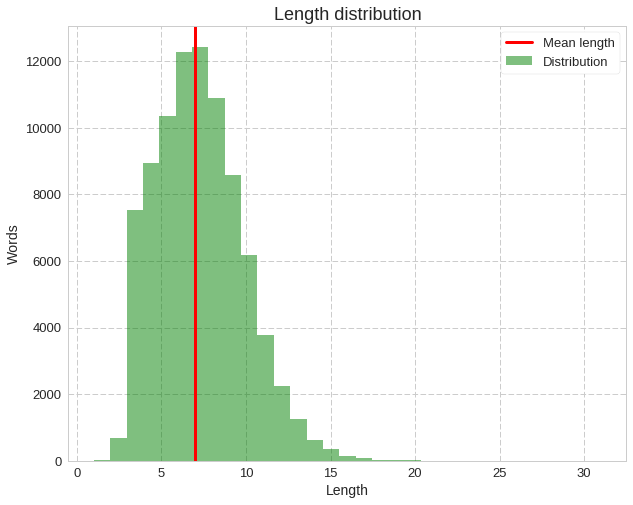

In [7]:
plt.hist(lengths, 31, normed=0, facecolor='green', alpha=0.5, label="Distribution")
plt.axvline(np.mean(lengths), color="r", lw=3, label="Mean length")
plt.xlabel("Length", fontsize=14)
plt.ylabel("Words", fontsize=14)
plt.title("Length distribution", fontsize=18)
plt.legend();

Here we also define all the constants in the separate file `params.py`. It is done for the sake of simplicity and to store all the parameters in one place

In [8]:
setting = params()
setting.words_per_epoch = 16000
setting._update()
print(setting)

----------------------------------------------------------------------------------------------------
absolute_max_string_len       16                                                                    
batch_size                    32                                                                    
epochs                        20                                                                    
filters                       16                                                                    
img_h                         64                                                                    
img_w                         512                                                                   
kernel_size                   (3, 3)                                                                
pool_size_1                   (4, 4)                                                                
pool_size_2                   (2, 2)                                                       

`TextImageGenerator` class allows to generate data dynamically during the trainig.

In [9]:
img_gen = TextImageGenerator(monogram_file='../data/wordlist_mono_clean.txt',
                             setting=setting)

Let's now build a word list from which we're going to sample. Here we want to restrict ourself to the word with length no more than 10 just for example purposes.

In [10]:
img_gen.build_word_list(max_string_len = 10)

These are the helper function to draw generated image in the pretty way

In [11]:
def fix_style(axes, xlabel=""):
    """
    Prettify the axes for OCR drawing
    
    Args:
        axes(plt.axes): axes to prettify
        xlabel(string): label for x axis
    
    Return:
        None
    """
    axes.grid(False)
    axes.tick_params(which="both", 
                     bottom="off", 
                     top="off", 
                     left="off", 
                     right="off",
                     labelbottom="off",
                     labelleft="off")
    axes.set_xlabel(xlabel)
    
def draw(img):
    """
    Draw the image for OCR
    
    Args:
        img(ndarray): image
    
    Return:
        None
    """
    plt.imshow(img, cmap="Greys_r")
    fix_style(plt.gca())

Let's see the example of the validation data

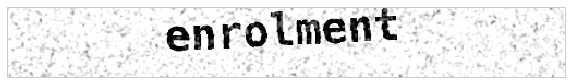

In [15]:
pic = next(img_gen.next_val())[0]["input_data"][0, :, :, 0]
draw(pic)

# CNN+RNN CTC Model

The architecture of the model here is quite complicated thus before proceeding with this notebook we strongly suggest you to go through the `RNN_MNIST` notebook which consequently enhances the model starting from very simple. 

Here we're using a ***Sequence-2-Sequence*** paradigm and ***CTC*** loss function. The general idea is the follwoing: let's treat every image as a sequence of columns of pixels as if one scans it from left to right.

The more detailed description of the architecture can be found below.

Also below one can find two sections:
* "*From scratch*" section creates and trains the model from the very beginning and saves it for later usage
* In the "*Pre-trained*" section we load the model trained before. If you don't want to spend a lot of time and traing your own model you can immediately proceed to this section

## From Scratch

In this section we build and train our model from scratch

Visualization, saving and validation callback. After each epoch it:
* Draws 6 randomly chosen words from validation set with real and predicted labels.
* Saves weights
* Checks *Edit Distance* on validation set

In [13]:
class ValCallback(Callback):

    def __init__(self, test_func, text_img_gen, val_words, num_display_words=6):
        """
        This callback is called after each epoch.
        It saves the weights of the model and draw
        an image with prediction and ground truth
        for 6 validation examples picked randomly.
        Also it calculates metrics (Edit distance and
        Normalized ED) on the validation set.
        
        Args:
            test_func(callable): TF function that accepts
                                 an image and produces the text
            text_img_gen(TextImageGenerator): instance of TextImageGenerator class 
                                              which is used for training
            val_words(int): number of words for the validation
            num_display_words(int): number of words to display
        """
        self.test_func = test_func
        self.output_dir = os.path.join(
            OUTPUT_DIR, datetime.datetime.now().strftime("%A, %d. %B %Y %I.%M%p"))
        self.text_img_gen = text_img_gen
        self.val_words = val_words
        self.num_display_words = num_display_words
        self.ed_hist = []
        self.norm_ed_hist = []
        os.makedirs(self.output_dir)

    def show_edit_distance(self, num):
        """
        Calculate the edit distance (ED) and normalized ED
        metrics for the validation set.
        
        Args:
            num(int): number of words to trace quality on.
                      possibly can be bigger than val_words
                      but it does not make sense.
        
        Return:
            None
        """
        # number of words to sample from generator
        num_left = num
        # variables to store overall metrics
        mean_norm_ed = 0.0
        mean_ed = 0.0
        # sampling cycle
        while num_left > 0:
            # take one batch of validation words
            word_batch = next(self.text_img_gen)[0]
            # number of words to process; can be less for the last batch
            num_proc = min(word_batch["input_data"].shape[0], num_left)
            # decode
            decoded_res = decode_batch(self.test_func, word_batch["input_data"][0:num_proc])
            # calculate metrics
            for j in range(0, num_proc):
                edit_dist = editdistance.eval(decoded_res[j], word_batch["source_str"][j])
                mean_ed += float(edit_dist)
                mean_norm_ed += float(edit_dist) / len(word_batch["source_str"][j])
            # update number of words left
            num_left -= num_proc
        # average cumulatuve metrics
        mean_norm_ed = mean_norm_ed / num
        mean_ed = mean_ed / num
        # apend to the history
        self.ed_hist.append(mean_ed)
        self.norm_ed_hist.append(mean_norm_ed)
        # print results
        print("\nOut of {0} samples:  Mean edit distance: {1:.3f} Mean normalized edit distance: {2:.3f}"\
              .format(num, mean_ed, mean_norm_ed))

    def on_epoch_end(self, epoch, logs={}):
        """
        This method is called by Keras after the end of every epoch.
        
        Args:
            epoch(int): number of epochs passed
            logs(dict): additional dictionary with logs
        
        Return:
            None
        """
        # save weights of the model
        
        self.model.save_weights(os.path.join(self.output_dir, "weights%02d.h5" % (epoch + 1)))
        
        # calculate ED and Normalized ED for validation set
        
        self.show_edit_distance(self.val_words)
        
        # draw 6 words from validation set for visual check
        
        # take one batch of words
        word_batch = next(self.text_img_gen)[0]
        # do a prediction and decode it into the sequence of letters
        res = decode_batch(self.test_func, word_batch["input_data"][0:self.num_display_words])
        # draw every prediction
        for i in range(self.num_display_words):
            plt.subplot(self.num_display_words, 1, i + 1)
            the_input = word_batch["input_data"][i, :, :, 0]
            plt.imshow(the_input, cmap="Greys_r")
            fix_style(plt.gca(), 
                      "Truth = \"{0}\"      Decoded = \"{1}\"".format(word_batch["source_str"][i], res[i]))
        # save figure
        fig = plt.gcf()
        fig.set_size_inches(10, 12)
        plt.savefig(os.path.join(self.output_dir, "e%02d.png" % (epoch + 1)), bbox_inches="tight")
        plt.close()

Check (and possibly change) the parameters which will be used later. There is a special `_update` method which recalculate all the dependencies in the parameters such that all of them are consistent.

In [14]:
setting = params()
setting.words_per_epoch = 16000
setting._update()
print(setting)

----------------------------------------------------------------------------------------------------
absolute_max_string_len       16                                                                    
batch_size                    32                                                                    
epochs                        20                                                                    
filters                       16                                                                    
img_h                         64                                                                    
img_w                         512                                                                   
kernel_size                   (3, 3)                                                                
pool_size_1                   (4, 4)                                                                
pool_size_2                   (2, 2)                                                       

Set the correct input dimension order for batch (Theano and Tensorflow has different). Here we're going to use TF notation where the channel dimension is the last.

In [15]:
input_shape = (setting.img_h, setting.img_w, 1)

Create an instance of TextImageGenerator class which generates training and validation data batch by batch (for further details see `ocr_utils.py`)

In [16]:
img_gen = TextImageGenerator(monogram_file="../data/wordlist_mono_clean.txt",
                             setting=setting)

### Build

Let's finally define the architecture of the network. Here we're going to use functional Keras API.

First layer is an input layer which accepts the initial images

In [17]:
input_data = Input(name="input_data", 
                   shape=input_shape, 
                   dtype="float32")

CNNs are known to be the best for images. So let's apply convolutional layer to detect some meaningful features. Also we want to apply max pooling on top of that to impose translational invariance to small movements as well as reduce the dimension

In [ ]:
cnn = Convolution2D(filters=setting.filters, 
                    kernel_size=setting.kernel_size, 
                    padding="same",
                    activation="relu", 
                    name="conv1")(input_data)
cnn = MaxPooling2D(pool_size=setting.pool_size_1, 
                   name="pool1")(cnn)

Let's apply the same block again to make our model deeper and more representative

In [18]:
cnn = Convolution2D(filters=setting.filters, 
                    kernel_size=setting.kernel_size, 
                    padding="same",
                    activation="relu", 
                    name="conv2")(cnn)
cnn = MaxPooling2D(pool_size=setting.pool_size_2, 
                   name="pool2")(cnn)

After that stage we have the output with the shape $(8, 64, 16)$. Here $8$ corresponds to the initial height dimension, $64$ corresponds to the initial width dimension and $16$ is for channel dimension.

Our text is placed horizontally mostly (with some small rotations). Let's slice the features maps across the width dimension and then flatten all the feature maps across the height dimension to get one feature vector which we can later pass to LSTM.

The principal scheme is shown below.

<img src="./diagram.png">

For now we have our width dimension on the second place. Let's first *permute* the order of the dimension such that the width becomes first one. This is needed because LSTM should apply 2D tensor with the dimensions $(\text{Timesteps}, \text{Features})$ and we want to have width dimension as timesteps. All these operations are done with `Permute` layer.

After doing a permution we can flatten our height dimension across feature maps. It can be done with `Reshape` layer.

In [19]:
hid = Permute((2, 1, 3), 
              name="permute")(cnn)
hid = Reshape(target_shape=(setting.time_steps, -1), 
              name="reshape")(hid)

The size of the feature dimension is 128 now. Let's cut it down before passing to LSTM. It can be done with simple `Dense` layer applied to each timesteps which can be achieved with `TimeDistributed` wrapper.

In [20]:
hid = TimeDistributed(Dense(setting.time_dense_size, activation="relu"), name="dense1")(hid)

Now we're finally ready to feed our vectors into recurrent network. After CNN feature detection part we hope that these vectors will be much more representative that the initial image columns.

Recurrent network is composed of two Bidirectional GRU layers stacked on top of each other. `Bidirectional` is just a wrapper from keras which specifies that input sequence should be fed in forward order as well as in reversed. It creates layer with twice number of units specified in the internal layer (here we have GRU with 512 units thus final bidirectional layer will have 1024). Then it splits all the units into two groups:
* Half of the units are given with forward order of the sequence
* Another half are given with reversed sequence

Also one can play around with the `merge_mode` which is responsible for combining the results of the forward and reversed directions. Here we're using `sum` in the first layer and `concat` in the second.

In [21]:
rnn = Bidirectional(GRU(units=setting.rnn_size, 
                        return_sequences=True), 
                    merge_mode="sum", 
                    name="gru1")(hid)
rnn = Bidirectional(GRU(units=setting.rnn_size, 
                        return_sequences=True), 
                    merge_mode="concat", 
                    name="gru2")(rnn)

After recurrent layers we're ready to classify sequnces. For that purpose let's use again `TimeDistributed` wrapper for `Dense` layer which can consequently apply `Dense` layer to all timesteps of the sequence.

The idea is to transforms RNN output to probability distribution over the characters.

In [22]:
out = TimeDistributed(Dense(units=img_gen.get_output_size(), 
                            activation="softmax"), 
                      name="softmax")(rnn)

That's the main part of our model. Let's compile it and see the summary

In [23]:
Model(inputs=[input_data], outputs=[out]).summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_data (InputLayer)      (None, 64, 512, 1)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 512, 16)       160       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 16, 128, 16)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 16, 128, 16)       2320      
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 8, 64, 16)         0         
_________________________________________________________________
permute_1 (Permute)          (None, 64, 8, 16)         0         
_________________________________________________________________
reshape (Reshape)            (None, 64, 128)           0         
__________

One big issue arises is the length of the output sequence. As one can see, the number of output steps is equal to the number of input. It means that we have 64 steps as an output while real output sequences contain no more than 16 (see restrictions in implementation of `TextImageGenerator` class). Moreover, real output sequences may vary in length which is even bigger problem.

To tackle this problem we're going to use ***CTC*** loss function. See lectures or [the original paper](http://www.cs.toronto.edu/~graves/icml_2006.pdf) for more details. One technical problem with this loss function is that is requires not only predictions, real labels and length of predictions (this can be achieved by masking) but also the length of the real label sequence which can differ from input length.

Currently Keras does not support additional parameters to the loss function. Thus the only way is to create input layers for each of the described parameters and then implement *CTC* loss computation in `Lambda` layer. `Lambda` layer allows to use any TF function for calculation of the outputs. Actually it is a poor way to implement new layer.

First of all, let's create `Input` layers for the required inputs.

In [ ]:
input_labels = Input(name='input_labels', shape=(img_gen.absolute_max_string_len,), dtype='float32')
input_length = Input(name='input_length', shape=(1,), dtype='int32')
label_length = Input(name='label_length', shape=(1,), dtype='int32')

Here the parameters should be the following:
* *input_labels* contains a sequence of real labels (characters) appended with $-1$ from the end to have equal length with all other sequences to be able to form a tensor.
* *input_length* is a 1D vector which contains the real length of the input; in case of our task the real input always has length of 64 (number of timesteps)
* *label_length* should contain the length of the word at the output

Now let's define described `Lambda` layer. Here we want to use `ctc_lambda_func` which is implemented in `ocr_utils.py`. It uses the inderlying *TensorFlow* function.

In [24]:
loss_out = Lambda(function=ctc_lambda_func, 
                  output_shape=(1,), 
                  name="ctc")([out, input_labels, input_length, label_length])

Now we can define our final model

In [ ]:
model = Model(inputs=[input_data, input_labels, input_length, label_length], outputs=[loss_out])

Notice that the generator in `TextImageGenerator` is built in such a way that it outputs the data in the required by this architecutre format. So you should not change anything by hand.

### Train

For training we're going to use simple **SGD** oprimizer with **Nesterov momentum** and gradient clipping to avoid vanishing gradients problem.

In [26]:
lr = 0.03
clipnorm = 5
sgd = SGD(lr=lr, decay=3e-7, momentum=0.9, nesterov=True, clipnorm=clipnorm)

Notice the the loss computation is done inside the network so the actual output of the network is not the predicted sequence of labels but the loss. It creates problems with prediction stage which will be resolved later. Now we should compile our model. Keras requires to explicitly provide loss function to compile model. Because the actual error computation has already been done (it is a prediction) let's just pass the prediction through the loss function (dummy loss function).

In [27]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)

Now let's create a TF function that takes our input image and outputs the sequence of probability distributions that would be later collapsed into real short character sequence.

In [ ]:
test_func = K.function([input_data], [out])

Now we're finally ready to train our network. Let's create an instance of the `ValCallback` defined above to trace training process.

In [28]:
cb = ValCallback(test_func, img_gen.next_val(), setting.val_words)

And set the number of epochs

In [29]:
setting.epochs = 20

The training is done in two stages:
* At the initial stage the task of the model is to learn translational invariance over the image. It seems to be the hard task. Thus we're starting with short words no more than **4** letters (see `on_train_begin` method of `TextImageGenerator`)
* When the translational invariance is learnt (10 epochs) we can start to feed longer words to our model (see `on_epoch_begin` method of `TextImageGenerator`). Now the maximum length is equal to **8**.

This gradual increase in complexity of words will hopefully ease the learning procedure.

In [30]:
hist = model.fit_generator(generator=img_gen.next_train(), 
                           steps_per_epoch=int(np.ceil(setting.train_words * 1. / setting.batch_size)),
                           epochs=setting.epochs, 
                           validation_data=img_gen.next_val(), 
                           validation_steps=int(np.ceil(setting.val_words * 1. / setting.batch_size)),
                           callbacks=[cb, img_gen])

/opt/conda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2252: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Epoch 1/20
399/400 [============================>.] - ETA: 0s - loss: 12.3109
Out of 3200 samples:  Mean edit distance: 3.625 Mean normalized edit distance: 1.000
400/400 [==============================] - 212s - loss: 12.3083 - val_loss: 12.6181
Epoch 2/20
399/400 [============================>.] - ETA: 0s - loss: 11.0390
Out of 3200 samples:  Mean edit distance: 3.625 Mean normalized edit distance: 1.000
400/400 [==============================] - 215s - loss: 11.0386 - val_loss: 12.6224
Epoch 3/20
399/400 [============================>.] - ETA: 0s - loss: 10.9846
Out of 3200 samples:  Mean edit distance: 3.367 Mean normalized edit distance: 0.932
400/400 [==============================] - 220s - loss: 10.9848 - val_loss: 12.5091
Epoch 4/20
399/400 [============================>.] - ETA: 0s - loss: 10.9234
Out of 3200 samples:  Mean edit distance: 3.235 Mean normalized edit distance: 0.899
400/400 [==============================] - 228s - loss: 10.9222 - val_loss: 12.4519
Epoch 5/20
3

### Save

Learning takes quite a lot of time so let's save out model for further usage. Model in Keras is composed of two parts:
* Architecture
* Weights

They should be saved separately. We was saving the weights after each epoch with `ValCallback` so here we don't need to do it again.

In [31]:
architecture = model.to_json()
with open(os.path.join(cb.output_dir, "architecture.json"), "w") as json_file:
    json_file.write(architecture)

Let's also save the history of the training (both CTC loss and Edit Distance loss) for further analysis

In [32]:
hist_full = pd.DataFrame(np.array([hist.history["loss"], 
                                   hist.history["val_loss"], 
                                   cb.ed_hist, 
                                   cb.norm_ed_hist]).T, 
                         columns=["Train CTC Loss", 
                                  "Test CTC Loss", 
                                  "Test Edit Distance", 
                                  "Test Normalized Edit Distance"], 
                         index=np.arange(1, setting.epochs + 1))

In [33]:
hist_full.to_csv(os.path.join(cb.output_dir, "hist.csv"))

## Pre-trained

Let's load early pre-trained model

In [16]:
model_dir = os.path.join(OUTPUT_DIR, "Saturday, 10. June 2017 05.04PM")

First of all, let's download the pre-trained weights. [Here](https://www.dropbox.com/s/urooqrx7ieoib4z/weights19.h5) is the link.

In [17]:
!wget https://www.dropbox.com/s/urooqrx7ieoib4z/weights19.h5
os.rename("weights19.h5", os.path.join(model_dir, "weights19.h5"))

--2017-06-12 22:31:20--  https://www.dropbox.com/s/fp85dy3h00b0vwm/weights19.h5
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/content_link/dJtHKBEsDlFZ5Vi7lw8F3mA35KKBqKzYL9RejhERr5OFfjukzMwbnfAvSso4t91W/file [following]
--2017-06-12 22:31:21--  https://dl.dropboxusercontent.com/content_link/dJtHKBEsDlFZ5Vi7lw8F3mA35KKBqKzYL9RejhERr5OFfjukzMwbnfAvSso4t91W/file
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.48.131
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.48.131|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19471576 (19M) [application/octet-stream]
Saving to: 'weights19.h5'

weights19.h5        100%[===================>]  18.57M  3.18MB/s    in 8.0s    

2017-06-12 22:31:31 (2.31 MB/s) - 'weights19.h5' saved [194715

Load architecture

In [18]:
with open(os.path.join(model_dir, "architecture.json")) as f:
    architecture = f.read()
model = model_from_json(architecture)

Reproduce the optimizer:

In [19]:
lr = 0.03
clipnorm = 5
sgd = SGD(lr=lr, decay=3e-7, momentum=0.9, nesterov=True, clipnorm=clipnorm)

Compile the model

In [20]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)

Now let's create a TF function that takes our input image and outputs the sequence of probability distributions that would be later collapsed into real short character sequence. We can't use simple predict becuase the CTC loss is computed through Lambda layer and is the actual output of the model. Fur further explanation see `Build` section above

In [21]:
test_func = K.function([model.layers[0].input],
                       [model.layers[-5].output])

Let's see the model architecture

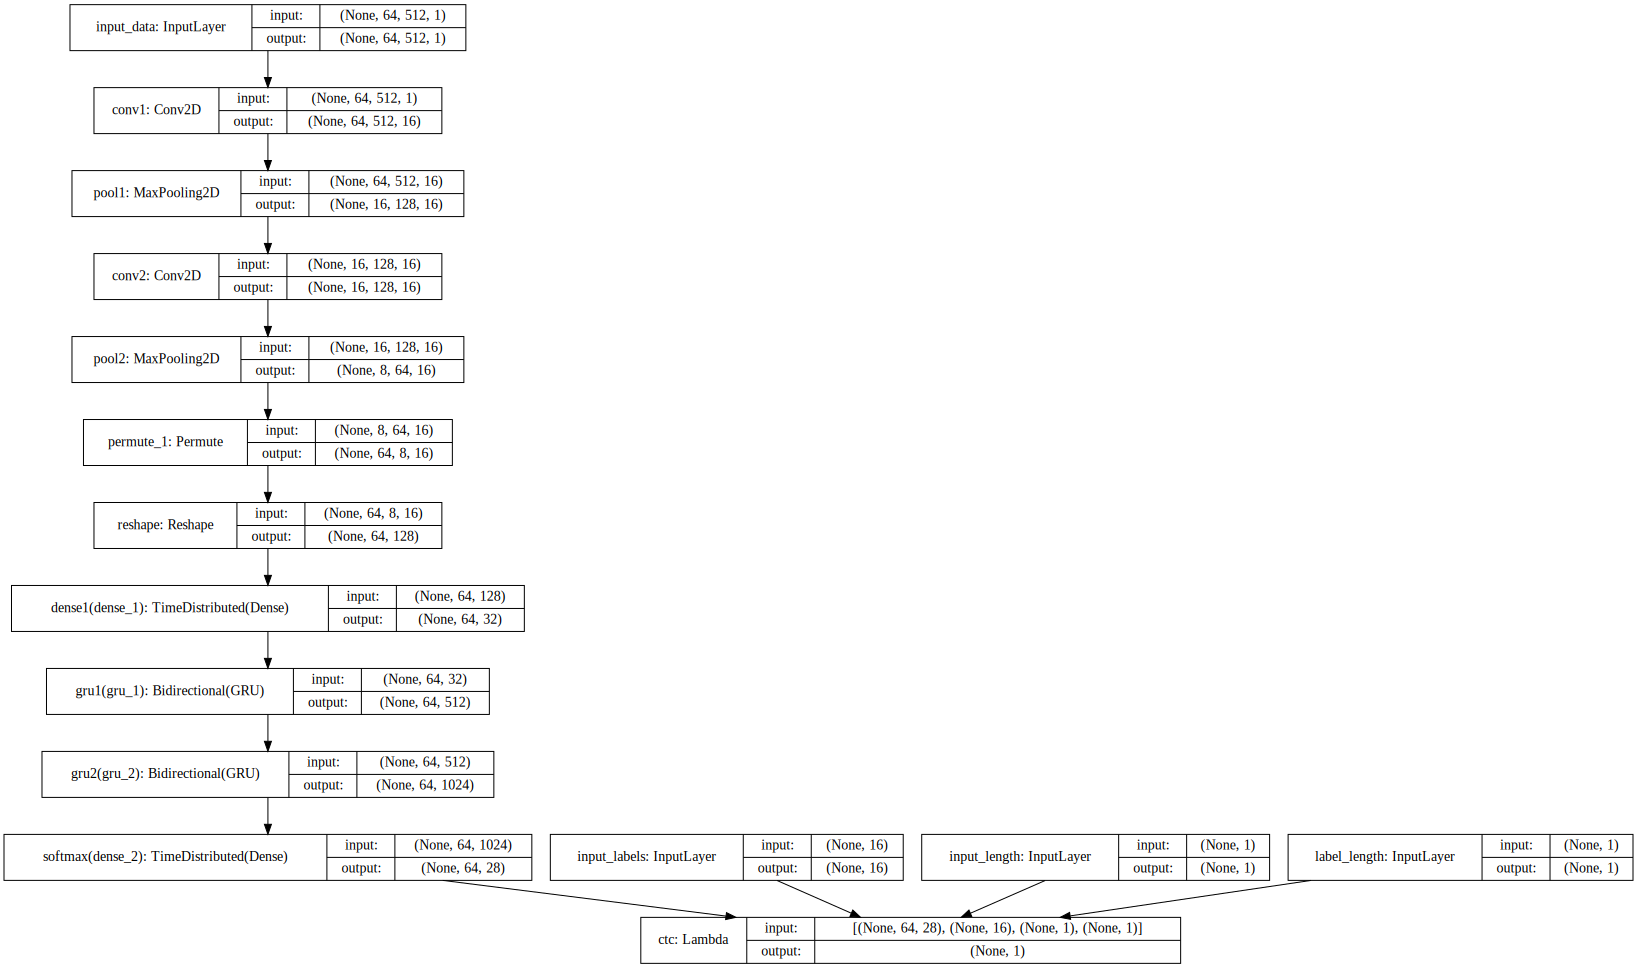

In [22]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

And finally load weights

In [23]:
model.load_weights(os.path.join(model_dir, "weights19.h5"))

And history

In [24]:
hist_full = pd.read_csv(os.path.join(model_dir, "hist.csv"), index_col=0)

# Evaluation

Let's see how well the training was done. Here we're going to explore three metrics:
* **CTC loss** (see lectures for the description)
* **Edit distance** - number of elementary operations (deletion, insertion, swapping) neede to transform one word to another
* **Normalized ED** - normalized version of edit distance; equals to the edit distance dividede by the length of target word.

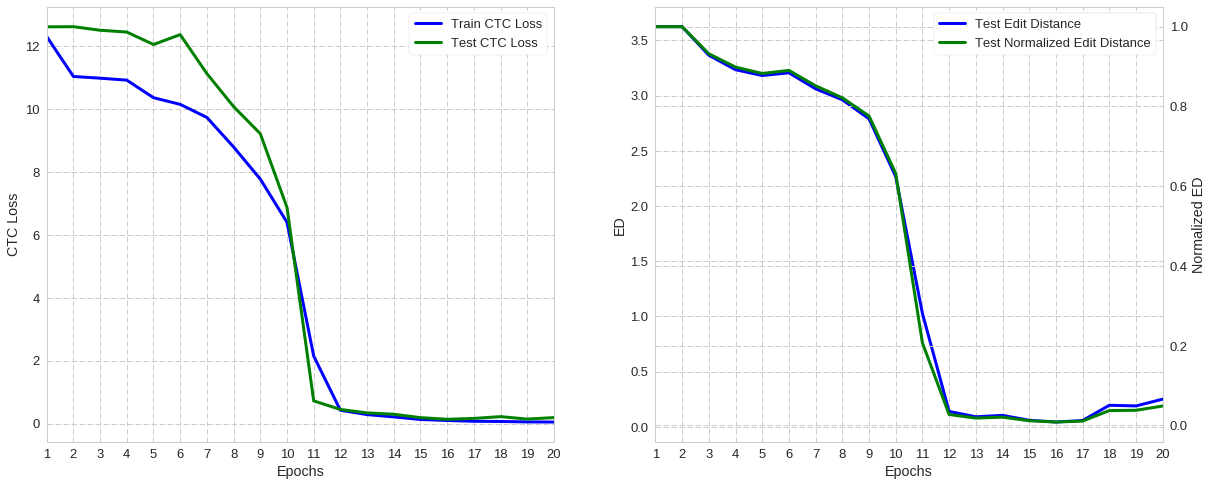

In [25]:
plt.figure(figsize=(20, 8))

ax = plt.subplot(121)
hist_full.plot(y=[0, 1], lw=3, ax=ax, style=["b", "g"])
plt.xticks(hist_full.index, hist_full.index)
plt.xlabel("Epochs")
plt.ylabel("CTC Loss")

ax = plt.subplot(122)
lns1 = hist_full.plot(y=[2], lw=3, ax=ax, style="b")
plt.xticks(hist_full.index, hist_full.index)
plt.xlabel("Epochs")
plt.ylabel("ED")
ax = ax.twinx()
lns2 = hist_full.plot(y=[3], lw=3, ax=ax, style="g")
lns = lns1.lines + lns2.lines
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)
plt.ylabel("Normalized ED")

plt.show()

As one can notice from the graph, mean edit distane almost equals to zero which means that almost all the words from the validation set are recognized correctly

# Interactive

Here one can try his/her own words with the length no more than 16 (longer words simply do not fit into the canvas).

In [32]:
string_list = ["asdbsfb", "vehicle", "personal", "diversification"]

Let's use special function (see `ocr_utils.py`) to put these words into the image

In [33]:
X_test, _ = generate_sample(string_list, setting)
y_test = X_test["source_str"]

There is a special function `decode_batch` defined in the `ocr_utils.py` which takes prediction function and images as an input, make predictions and decode them into the word sequence. Note that there is an option to use ***beam search*** for decoding the sequence. Implementation of decoding is done with TF routine for CTC.

In [34]:
preds = decode_batch(test_func, X_test["input_data"])

Let's see how good are our predictions

In [35]:
mean_ed = 0.0
mean_norm_ed = 0.0
for i in range(len(y_test)):
    mean_ed += float(editdistance.eval(y_test[i], preds[i]))
    mean_norm_ed += float(editdistance.eval(y_test[i], preds[i])) / float(len(y_test[i]))
mean_ed /= len(y_test)
mean_norm_ed /= len(y_test)
print("Mean edit distance : ", round(mean_ed, 3))
print("Mean normed edit distance : ", round(mean_norm_ed, 3))

Mean edit distance :  0.0
Mean normed edit distance :  0.0


And look at them in the visual format

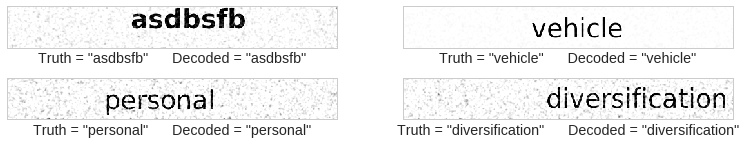

In [36]:
plt.figure(figsize=(13, 1.2 * int(np.ceil(len(string_list) * 1. / 2))))
for i in range(len(string_list)):
    plt.subplot(int(np.ceil(len(string_list) * 1. / 2)), 2, i + 1)
    draw(X_test["input_data"][i, :, :, 0])
    plt.xlabel("Truth = \"{0}\"      Decoded = \"{1}\"".format(X_test['source_str'][i], preds[i]))

Get the raw probability distributions (without decoding them into the sequence of letters)

In [37]:
preds_distro = test_func([X_test["input_data"]])[0]

As you should know till this point, CTC introduces additional **NULL** label which corresponds to the absence of the any other label. For the error computation is is collapsed and removed in the sensible way.

In TF implementation NULL class is always the last one.

Let's take one interactive example (e.g. the first one, note that it is correctly recognized) and see when (in terms of timesteps) do we predict real letter and when do we predict NULL label. In other words let's see where the letters are detected using our approach.

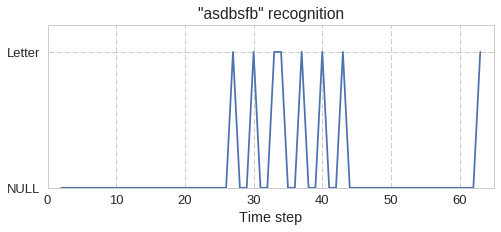

In [38]:
plt.figure(figsize=(8, 3))
plt.plot(np.arange(2, preds_distro.shape[1]), np.argmax(preds_distro[0][2:], axis=1) < 27)
plt.ylim([0.0, 1.2])
plt.xlim([0, 65])
plt.yticks([0.0, 1.0], ["NULL", "Letter"])
plt.xlabel("Time step")
plt.title("\"" + string_list[0] + "\" recognition");

As one can see the recognition pikes are and the initial letters in the image are in the same part of the timesteps/columns. That's great! It means that our algorithm works right.

Let's also take a look into another interesting feature. Let's draw the probability of the most probable label across the sequence. Moreover, different colors represent different predicted labels

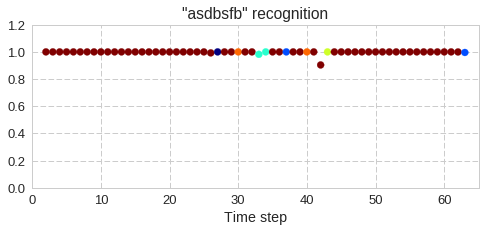

In [39]:
plt.figure(figsize=(8, 3))
word_num = 0
dic = np.unique(np.argmax(preds_distro[word_num], axis=1)[2:])
plt.scatter(np.arange(preds_distro.shape[1])[2:], 
            np.max(preds_distro[word_num][2:], axis=1), 
            c=np.array(list(map(lambda x: np.where(dic == x)[0][0], 
                                np.argmax(preds_distro[word_num], axis=1)[2:]))), cmap="jet")
plt.ylim(0, 1.2)
plt.xlim(0, 65)
plt.xlabel("Time step")
plt.title("\"" + string_list[0] + "\" recognition");